In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

ModuleNotFoundError: No module named 'pandas'

In [5]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

NameError: name 'pd' is not defined

In [4]:
print(df.shape)
print(df.info())
print(df.isnull().sum())


NameError: name 'df' is not defined

In [9]:
# Step 2: Handle missing values

# Replace empty strings with NaN
df = df.replace(" ", np.nan)

# Convert TotalCharges to numeric
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')

# Fill numeric NaNs with median
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

# Fill categorical NaNs with mode
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

In [10]:
# Step 3: Normalize numerical data

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [14]:
from sklearn.preprocessing import OneHotEncoder

# Use sparse_output=False instead of sparse=False
encoder = OneHotEncoder(drop='first', sparse_output=False)

encoded = encoder.fit_transform(df[cat_cols])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(cat_cols))

df = pd.concat([df.drop(columns=cat_cols), encoded_df], axis=1)


In [12]:
# Step 5: Feature engineering
# ---------------------------
# Example features:
# - Purchase frequency (assuming MonthlyCharges as proxy for frequency here)
df['purchase_frequency'] = df['MonthlyCharges']  # if transaction-level data available, count per month


In [13]:
# - Engagement score: example = online security + online backup + tech support (binary yes/no)
# If these exist as dummy variables after encoding, sum them
engagement_features = [col for col in df.columns if "OnlineSecurity" in col
                       or "OnlineBackup" in col or "TechSupport" in col]
df['engagement_score'] = df[engagement_features].sum(axis=1)

# - Subscription tenure in months (already 'tenure' column)
df['subscription_tenure'] = df['tenure']

print(df.head())

   customerID  gender  SeniorCitizen Partner Dependents    tenure  \
0  7590-VHVEG  Female      -0.439916     Yes         No -1.277445   
1  5575-GNVDE    Male      -0.439916      No         No  0.066327   
2  3668-QPYBK    Male      -0.439916      No         No -1.236724   
3  7795-CFOCW    Male      -0.439916      No         No  0.514251   
4  9237-HQITU  Female      -0.439916      No         No -1.236724   

  PhoneService     MultipleLines InternetService OnlineSecurity  ...  \
0           No  No phone service             DSL             No  ...   
1          Yes                No             DSL            Yes  ...   
2          Yes                No             DSL            Yes  ...   
3           No  No phone service             DSL            Yes  ...   
4          Yes                No     Fiber optic             No  ...   

  StreamingMovies        Contract PaperlessBilling              PaymentMethod  \
0              No  Month-to-month              Yes           Electronic

In [15]:
#Supervised models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Features & Target
X = df.drop(columns=['Churn'])
y = df['Churn']  # Make sure this is 0/1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=200),
    "XGBoost": XGBClassifier(eval_metric='logloss', use_label_encoder=False),
    "LightGBM": LGBMClassifier()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    print(f"{name} - AUC: {auc:.4f}")
    print(classification_report(y_test, preds))


KeyError: "['Churn'] not found in axis"

In [ ]:
#Deep learning model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

ann = Sequential()
ann.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
ann.add(Dropout(0.3))
ann.add(Dense(32, activation='relu'))
ann.add(Dense(1, activation='sigmoid'))

ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
ann.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)


In [ ]:
#Unsupervised learning
#K-Means Clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X)
df['Cluster'] = clusters


In [ ]:
#Unsupervised learning
#DBSCAN for anomaly detection
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=3, min_samples=5)
labels = dbscan.fit_predict(X)
df['Anomaly'] = labels  # -1 means anomaly



Sales Trend Analysis

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Example: loading your transactions data
# transaction = pd.read_csv("transactions.csv", parse_dates=['date'])

# Ensure date is datetime
transaction['date'] = pd.to_datetime(transaction['date'])

# Extract month, quarter, year
transaction['month'] = transaction['date'].dt.to_period('M')
transaction['quarter'] = transaction['date'].dt.to_period('Q')
transaction['year'] = transaction['date'].dt.year

# Monthly sales trend
monthly_sales = transaction.groupby('month')['amount'].sum()

plt.figure(figsize=(10,5))
monthly_sales.plot(kind='line', marker='o')
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.grid(True)
plt.show()

# Quarterly sales
quarterly_sales = transaction.groupby('quarter')['amount'].sum()

# Yearly sales
yearly_sales = transaction.groupby('year')['amount'].sum()

print("Monthly Sales:\n", monthly_sales)
print("\nQuarterly Sales:\n", quarterly_sales)
print("\nYearly Sales:\n", yearly_sales)


NameError: name 'transaction' is not defined

In [ ]:
churn_revenue = df.merge(transaction, on='customerID').groupby('Churn')['amount'].sum()
print(churn_revenue)


In [ ]:

# 1. Example transaction data

# transaction = pd.read_csv("transactions.csv", parse_dates=['date'])
# For demo, let's create dummy data:
import numpy as np
np.random.seed(42)
dates = pd.date_range(start="2023-01-01", end="2023-12-31", freq='D')
transaction = pd.DataFrame({
    'date': np.random.choice(dates, 500),
    'amount': np.random.randint(50, 500, size=500),
    'product': np.random.choice(['Product A', 'Product B', 'Product C'], size=500)
})


In [20]:
# 2. Prepare time-based fields

transaction['month'] = transaction['date'].dt.to_period('M')
transaction['month_str'] = transaction['month'].astype(str)
transaction['year'] = transaction['date'].dt.year


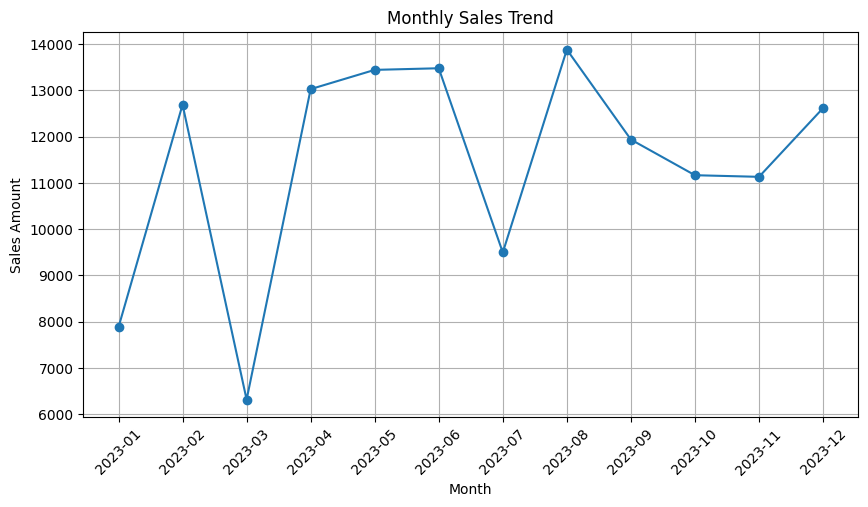

In [21]:
# 3. Line Chart – Monthly Sales Trend

monthly_sales = transaction.groupby('month_str')['amount'].sum().reset_index()

plt.figure(figsize=(10,5))
plt.plot(monthly_sales['month_str'], monthly_sales['amount'], marker='o')
plt.xticks(rotation=45)
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Sales Amount")
plt.grid(True)
plt.show()

# Plotly interactive version
fig_line = px.line(monthly_sales, x='month_str', y='amount',
                   title="Monthly Sales Trend", markers=True)
fig_line.show()

/tmp/ipython-input-1320889643.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




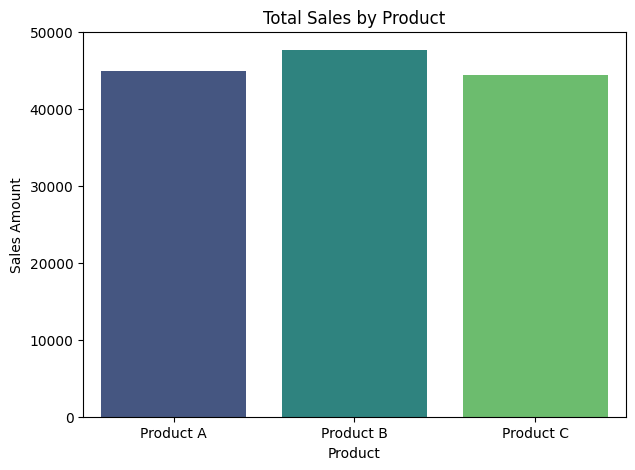

In [22]:
# 4. Bar Chart – Top Performing Products

product_sales = transaction.groupby('product')['amount'].sum().reset_index()

plt.figure(figsize=(7,5))
sns.barplot(data=product_sales, x='product', y='amount', palette='viridis')
plt.title("Total Sales by Product")
plt.xlabel("Product")
plt.ylabel("Sales Amount")
plt.show()

# Plotly interactive version
fig_bar = px.bar(product_sales, x='product', y='amount',
                 title="Total Sales by Product", color='product')
fig_bar.show()


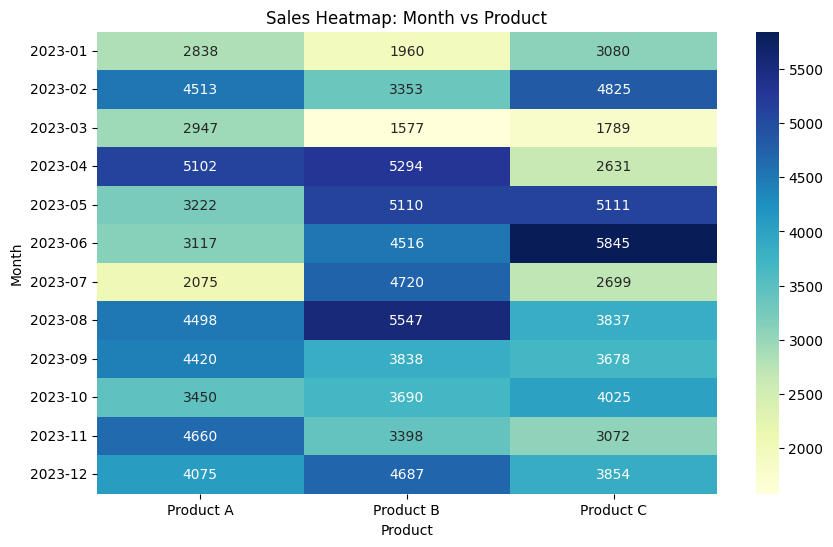

In [23]:
# 5. Heatmap – Sales by Month & Product

heatmap_data = transaction.groupby(['month_str', 'product'])['amount'].sum().unstack(fill_value=0)

plt.figure(figsize=(10,6))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Sales Heatmap: Month vs Product")
plt.xlabel("Product")
plt.ylabel("Month")
plt.show()